#### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(3)

In [3]:
FILE_PATH = "data/train.csv"

### Lightweight Data Wrangling

In [9]:
data = pd.read_csv(FILE_PATH).iloc[:, 1:]  # removing the first Id column

In [27]:
len(data.columns), len(data)

(80, 1460)

In [23]:
n_cols = len(data.columns)
numerical_cols = [col for col in data.columns if ('int64' == data.loc[:, col].dtype or 'float64' == data.loc[:, col].dtype)]
len(numerical_cols), numerical_cols

(37,
 ['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold',
  'SalePrice'])

In [26]:
data.loc[:, numerical_cols].isna().sum(0)

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [33]:
for ncol in numerical_cols:
    arr = data.loc[:, ncol].values
    n_uniques = len(np.unique(arr))
    if n_uniques <= 50:
        print(ncol, "embedding", n_uniques)
        continue
    if arr.min() >= 0:
        print(ncol, "log normalize")
        arr = np.log(1.0 + arr)
    else:
        print(ncol, "regular")
    mean = arr.mean()
    std = ((arr - mean) ** 2).mean()
    a5, a95 = mean - std * 1.96, mean + std * 1.96
    tq5, tq95 = (arr <= a5).mean(), (arr >= a95).mean()
    print(ncol, tq5, tq95)
    

MSSubClass embedding 15
LotFrontage regular
LotFrontage 0.0 0.0
LotArea log normalize
LotArea 0.11027397260273973 0.0821917808219178
OverallQual embedding 10
OverallCond embedding 9
YearBuilt log normalize
YearBuilt 0.4684931506849315 0.5164383561643836
YearRemodAdd log normalize
YearRemodAdd 0.42397260273972603 0.5698630136986301
MasVnrArea regular
MasVnrArea 0.0 0.0
BsmtFinSF1 log normalize
BsmtFinSF1 0.0 0.0
BsmtFinSF2 log normalize
BsmtFinSF2 0.0 0.0
BsmtUnfSF log normalize
BsmtUnfSF 0.0 0.0
TotalBsmtSF log normalize
TotalBsmtSF 0.025342465753424658 0.0
1stFlrSF log normalize
1stFlrSF 0.2842465753424658 0.2773972602739726
2ndFlrSF log normalize
2ndFlrSF 0.0 0.0
LowQualFinSF embedding 24
GrLivArea log normalize
GrLivArea 0.2684931506849315 0.24863013698630138
BsmtFullBath embedding 4
BsmtHalfBath embedding 3
FullBath embedding 4
HalfBath embedding 3
BedroomAbvGr embedding 8
KitchenAbvGr embedding 4
TotRmsAbvGrd embedding 12
Fireplaces embedding 4
GarageYrBlt regular
GarageYrBlt 0.0 

<AxesSubplot:>

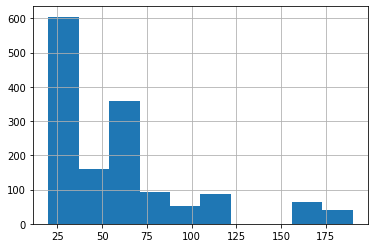

In [29]:
data.MSSubClass.hist()

In [9]:
X = data.iloc[:, 1:-3].values
Y = data.iloc[:, -3:].values

In [10]:
n = X.shape[0]
X.shape, Y.shape, n

((7111, 8), (7111, 3), 7111)

In [11]:
shuffle_seed = np.random.seed(15)
index_train, index_val = np.split(np.random.permutation(n), [int(n * 0.8)])

In [12]:
X_train, Y_train = X[index_train], Y[index_train]

In [13]:
means, stds = X_train.mean(0, keepdims=True), X_train.std(0, keepdims=True)
assert stds.min() > 0.0

In [14]:
X_train = (X_train - means) / stds

### Save for ML

In [15]:
import jax
import jax.random as random
import optax

In [21]:
p, m = X_train.shape[1], Y_train.shape[1]
num_h_layers = 0
h = 16  # hidden layer size
lr = 1e-4  # learning rate
num_epochs = 2
batch_size = 32

jax_poisson = jax.vmap(jax.jit(poisson_loss), in_axes=0)
jax_squared = jax.vmap(jax.jit(squared_loss), in_axes=0)

In [22]:
trained_params = train(rng=random.PRNGKey(15),
      model=MLP([h for _ in range(num_h_layers)] + [m]),
      optimizer=optax.adam(lr),
      dataset=get_dataset(X_train, Y_train, batch_size),
      loss_fn=jax_squared,
      metric_fn=lambda a, b: jnp.sqrt(jax_squared(a, b)),
      num_epochs=num_epochs,
      inputs_shape=(1, p)
     )

Step 25, Metric: 64.284, Loss: 18521.490


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7febc981cee0>
Traceback (most recent call last):
  File "/home/arnaud15/miniconda3/envs/jax/lib/python3.9/weakref.py", line 367, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Step 50, Metric: 75.997, Loss: 29222.572
Step 75, Metric: 85.385, Loss: 34530.777


KeyboardInterrupt: 

## Roadmap
- [x] load data into a tf dataset in memory 
- [x] create a dummy MLP and training loop
- [x] debug MLP on linear regression
- [x] Add dummy regularization and make it a baby resnet
    - Going for dropout and weight decay
- [ ] Split code nicely into several files
- [ ] Unit tests
    - Understand how to specify neural net parameters init
    - Understand init rngs and nn.module
    - debug simple resnet training
- [ ] Checkpointing and evaluation
- [ ] Tensorboard
- [ ] Baby version submission
- [ ] GPU training on AWS
- [ ] Rayon for training on several instances at the same time
- [ ] Go all in on hyperparameters tuning

### Notes
- Understand `nn.compact`
- Check out the source code for their train state

In [23]:
n = 10000
p = 10

key = random.PRNGKey(1515)
key, init_key = random.split(key)
X_linear = random.normal(init_key, shape=(n, p))
key, init_key = random.split(key)
beta = random.uniform(init_key, shape=(p,))
key, init_key = random.split(key)
noise = random.normal(init_key, shape=(n,))

y_linear = noise + X_linear.dot(beta)

In [47]:
trained_params = train(rng=random.PRNGKey(15),
      model=Resnet([10, 1]),
      optimizer=optax.sgd(5 * 1e-3),
      dataset=get_dataset(X_linear, y_linear, batch_size=32),
      loss_fn=jax_squared,
      metric_fn=jax_squared,
      num_epochs=5,
      inputs_shape=(1, p),
      l2_scale=1e-3,
     )

InvalidRngError: Dropout_0 needs PRNG for "dropout" (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.InvalidRngError)

In [48]:
beta

DeviceArray([0.598, 0.801, 0.642, 0.097, 0.51 , 0.226, 0.171, 0.31 ,
             0.386, 0.39 ], dtype=float32)

In [49]:
test_key = random.PRNGKey(12097341324)
test_input = random.normal(test_key, shape=(10,))
test_input.dot(beta)

DeviceArray(0.406, dtype=float32)

In [50]:
void_resnet = Resnet([10, 1])

void_resnet.init(test_key, test_input)

InvalidRngError: Dropout_0 needs PRNG for "dropout" (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.InvalidRngError)

In [51]:
void_resnet.apply(trained_params, test_input, train=False)

DeviceArray([0.042], dtype=float32)